In [ ]:
# 구글 드라이버 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/PlaydataFinalProject

/content/drive/MyDrive/PlaydataFinalProject


In [ ]:
 # import the necessary packages
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical



np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
# 하이퍼 파라미터
LEARNING_RATE = 0.001
N_EPOCHS = 50
N_BATCHS = 50
N_CLASS = 4 # 클래스 개수
CLASS_MODE = 'categorical'
INPUT_SHAPE = (640, 360, 3) # 학습할 이미지 shape
IMAGE_SIZE = 224
IMAGE_SIZE2 = 224

BASE_PATH = ''
ORIGINAL_PATH = './data/original'
AUGMENT_PATH = './data/augmentImg'
train_dir = './inputdata_preprocessing/classedImg/train'
validation_dir = './inputdata_preprocessing/classedImg/val'
test_dir = './inputdata_preprocessing/classedImg/test'

In [ ]:
# 데이터 셋 나누기
# 기존데이터 디렉토리 지우기
shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(validation_dir, ignore_errors=True)
shutil.rmtree(test_dir, ignore_errors=True)

os.makedirs(train_dir,exist_ok=True)
os.makedirs(validation_dir,exist_ok=True)
os.makedirs(test_dir,exist_ok=True)

img_file_list = os.listdir(ORIGINAL_PATH)
img_file_list.sort()

for i in range(len(img_file_list)): # 라벨폴더별
    label = img_file_list[i]

    train_under_dir = os.path.join(train_dir, label)
    validation_under_dir = os.path.join(validation_dir, label)
    test_under_dir = os.path.join(test_dir,label)

    os.makedirs(train_under_dir, exist_ok=True)
    os.makedirs(validation_under_dir, exist_ok=True)
    os.makedirs(test_under_dir, exist_ok=True)

    tmp_img_path = os.path.join(ORIGINAL_PATH, label)
    img_list = os.listdir(tmp_img_path)
    train_len= int(len(img_list)*0.7) # 70% train data
    val_len = int(len(img_list)*0.9) # 20% val data, test = 10%
    random.shuffle(img_list)

    count = 0
    for img_name in img_list:
        if count < train_len:
            shutil.copy(os.path.join(tmp_img_path,img_name), os.path.join(train_under_dir, img_name))
        elif count < val_len:
            shutil.copy(os.path.join(tmp_img_path,img_name), os.path.join(validation_under_dir, img_name))
        else:
            shutil.copy(os.path.join(tmp_img_path,img_name), os.path.join(test_under_dir, img_name))
        count+=1

# train, val, test 각폴더내 데이터 개수
data_cnts = []
for dirs in [train_dir, validation_dir, test_dir]:
    cnt = 0
    for (path, dir, files) in os.walk(dirs):
        cnt += len(files)
    data_cnts.append(cnt)
print(data_cnts)

[831, 237, 121]


In [ ]:
def get_generators():
    '''
    train, validation, test generator를 생성해서 반환.
    train generator는 image 변환 처리
    '''
    # 상하좌우 이동, 확대로 증강
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       zoom_range=0.2,
                                       height_shift_range=0.1,
                                       width_shift_range=0.1,
                                       brightness_range=[0.4,1.2],
                                       fill_mode='nearest'
                                       )

    test_datagen = ImageDataGenerator(rescale=1/255) #validation/test에서 사용

    # generator 들 생성
    # 첫번째는 먼저 한동작이므로 동작과 비동작으로 바이너리 구분만
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(IMAGE_SIZE2,IMAGE_SIZE),
                                                        batch_size=N_BATCHS,
                                                        class_mode=CLASS_MODE)
    val_generator = test_datagen.flow_from_directory(validation_dir,
                                                     target_size=(IMAGE_SIZE2,IMAGE_SIZE),
                                                     batch_size=N_BATCHS,
                                                     class_mode=CLASS_MODE)
    test_generator = test_datagen.flow_from_directory(test_dir,
                                                      target_size=(IMAGE_SIZE2,IMAGE_SIZE),
                                                      batch_size=N_BATCHS,
                                                      class_mode=CLASS_MODE)
    return train_generator, val_generator, test_generator

In [ ]:
# 결과 출력 function
def plot_result(history, ymin=0, ymax=1.0):
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(range(1,N_EPOCHS+1), history.history['loss'], label="train_loss")
    plt.plot(range(1,N_EPOCHS+1), history.history['val_loss'], label="val_loss")
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.ylim(ymin,ymax)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1,N_EPOCHS+1), history.history['accuracy'], label="train_accuracy")
    plt.plot(range(1,N_EPOCHS+1), history.history['val_accuracy'], label="val_accuracy")
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(ymin,ymax)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def create_model():
    conv_base = MobileNetV2(input_shape=(IMAGE_SIZE2,IMAGE_SIZE,3),
                            weights='imagenet',
                            include_top=False,
                            input_tensor=Input(shape=(IMAGE_SIZE2, IMAGE_SIZE,3))
                            )
    conv_base.trainable=False 
    model = keras.Sequential()
    model.add(conv_base)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dense(128))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())


    # 출력
    model.add(layers.Dense(N_CLASS, activation='softmax'))

    return model

In [ ]:
model = create_model()
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy', metrics=['accuracy']
              )

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
___________________________________________________________

In [ ]:
train_iterator, validation_iterator, test_iterator = get_generators()

Found 831 images belonging to 4 classes.
Found 237 images belonging to 4 classes.
Found 121 images belonging to 4 classes.


In [ ]:
# 학습 설정 콜백 함수
MODEL_PATH = './models'


In [ ]:
history = model.fit(train_iterator,
                    epochs=N_EPOCHS,
                    steps_per_epoch=len(train_iterator),
                    validation_data=validation_iterator,
                    validation_steps=len(validation_iterator),
                    )


Epoch 1/50
17/17 [==============================] - 256s 13s/step - loss: 0.7212 - accuracy: 0.6763 - val_loss: 0.4191 - val_accuracy: 0.7890
Epoch 2/50
17/17 [==============================] - 15s 877ms/step - loss: 0.4016 - accuracy: 0.8291 - val_loss: 0.3160 - val_accuracy: 0.8861
Epoch 3/50
17/17 [==============================] - 15s 878ms/step - loss: 0.3465 - accuracy: 0.8436 - val_loss: 0.3426 - val_accuracy: 0.8143
Epoch 4/50
17/17 [==============================] - 15s 874ms/step - loss: 0.3115 - accuracy: 0.8544 - val_loss: 0.2543 - val_accuracy: 0.8945
Epoch 5/50
17/17 [==============================] - 15s 863ms/step - loss: 0.2793 - accuracy: 0.8857 - val_loss: 0.2542 - val_accuracy: 0.8861
Epoch 6/50
17/17 [==============================] - 15s 872ms/step - loss: 0.2560 - accuracy: 0.9001 - val_loss: 0.2978 - val_accuracy: 0.8650
Epoch 7/50
17/17 [==============================] - 15s 872ms/step - loss: 0.2726 - accuracy: 0.8833 - val_loss: 0.2567 - val_accuracy: 0.8650


In [ ]:
# 모델 저장
t = datetime.datetime.now()
ttime = t.strftime('%Y-%m-%d_%H-%M-%S')

save_model_path = os.path.join(MODEL_PATH, f'MobileNetV2Colab-{ttime}.h5')
model.save(save_model_path, save_format='h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# test evaluation
model.evaluate(test_iterator)

3/3 [==============================] - 16s 8s/step - loss: 0.1011 - accuracy: 0.9752


[0.1010705754160881, 0.9752066135406494]

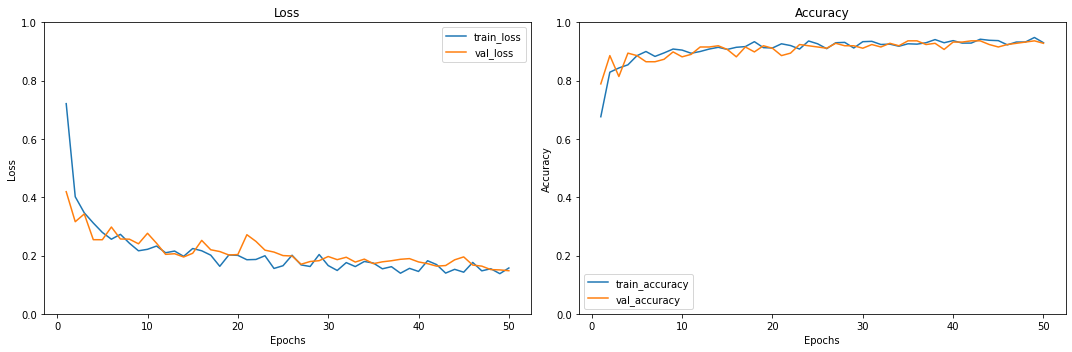

In [ ]:
plot_result(history)